# Homework 4 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3 as sql
import re

**From previous work:**

In [41]:
# Load cell phones data
cell_phones_data = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/cell_phones_total.csv")

# Function to convert values like 'k', 'M', 'B' to numeric
def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.strip()  # Remove extra spaces
        multipliers = {'k': 1e3, 'M': 1e6, 'B': 1e9}
        for suffix, multiplier in multipliers.items():
            if value.endswith(suffix):
                return float(value.replace(suffix, '')) * multiplier
        try:
            return float(value)  # Try converting to float if not a k/M/B value
        except ValueError:
            return np.nan  # If it can't be converted, return NaN
    return value

# Apply the conversion function to all relevant columns (skip the first one which is iso-3)
cell_phones_data.iloc[:, 1:] = cell_phones_data.iloc[:, 1:].apply(lambda col: col.apply(convert_to_numeric))

# Rensa och behåll endast användbara kolumner
clean_phone_data = cell_phones_data.copy()

cell_phones_data.ffill(axis=0, inplace=True)  # Forward fill missing values (fill NaNs with the previous row's value)
cell_phones_data.fillna(0, inplace=True)  # Fill any remaining NaNs with 0
cell_phones_data = cell_phones_data.infer_objects()  # Ensures proper type inference after filling

# Sort by the year 2015 and display a sample of cleaned data
sorted_data = cell_phones_data.sort_values(by='2015', ascending=False)
print("\nCleaned Data Sample:")
sorted_data[['iso-3', '2015', '2016', '2017', '2018', '2019']].head()



Cleaned Data Sample:


/var/folders/vy/kb_s3qdd3xj6h795w_sb9qxw0000gn/T/ipykernel_45575/523212968.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cell_phones_data.ffill(axis=0, inplace=True)  # Forward fill missing values (fill NaNs with the previous row's value)


,iso-3,2015,2016,2017,2018,2019
35,CHN,1.290000e+09,1.360000e+09,1.470000e+09,1.650000e+09,1.730000e+09
87,IND,1.000000e+09,1.130000e+09,1.170000e+09,1.180000e+09,1.150000e+09
200,USA,3.820000e+08,3.960000e+08,4.000000e+08,4.220000e+08,4.780000e+06
86,IDN,3.390000e+08,3.860000e+08,4.350000e+08,3.190000e+08,3.450000e+08
26,BRA,2.580000e+08,2.440000e+08,2.180000e+08,2.070000e+08,2.550000e+05


# Joining Data

In [13]:
# Load population data
pop_data = pd.read_csv('https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv')

# Substitute NaN values in the 2020 column with 0 in preparation for backward filling.
if '2020' in pop_data.columns:
    pop_data['2020'] = pop_data['2020'].fillna(0)

# Apply backward filling to fill in any remaining missing values.
clean_pop_data = pop_data.bfill(axis=1).iloc[:, 1:]  

# Display the cleaned population data
clean_pop_data.head()

,iso-3,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,ABW,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,59522.0,59471.0,...,101288.0,102112.0,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0
1,AFE,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,153955516.0,158313235.0,162875171.0,...,537792950.0,552530654.0,567892149.0,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0
2,AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,10010030.0,10247780.0,...,29249157.0,30466479.0,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0
3,AFW,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,110798486.0,113319950.0,115921723.0,...,366489204.0,376797999.0,387204553.0,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0
4,AGO,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,5787044.0,5827503.0,5868203.0,...,24259111.0,25188292.0,26147002.0,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0


Here I load the population data and handle missing values. I replace NaNs in the 2020 column with 0 and apply backward filling to fill other missing values. The result is a cleaned dataset ready for analysis.

**We start by pivoting the tables into the correct format and show the resulting table after pivoting:** 

In [42]:
#reshaping the dataframe
melt_phone_data = clean_phone_data.melt(id_vars='iso-3', var_name='year', value_name='n_cellphones')
melt_pop_data = clean_pop_data.melt(id_vars='iso-3', var_name='year', value_name='population')

data = melt_phone_data.merge(melt_pop_data, on = ['iso-3', 'year'])
data.head()

,iso-3,year,n_cellphones,population
0,ABW,1960,0.0,54608.0
1,AFG,1960,0.0,8622466.0
2,AGO,1960,0.0,5357195.0
3,ALB,1960,0.0,1608800.0
4,AND,1960,0.0,9443.0


This code reshapes the clean_phone_data and clean_pop_data dataframes using the melt function to turn them into long format. It then merges both reshaped datasets on the iso-3 and year columns, resulting in a combined dataframe with columns for iso-3, year, n_cellphones, and population. The first few rows of the merged data are then displayed.

In [23]:
# Loading country data from a CSV file and renaming the 'alpha-3' column to 'iso-3' for consistency with the other datasets 
country_data = pd.read_csv('https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv')\
    .rename(columns={'alpha-3':'iso-3'})
country_data.head()

,name,alpha-2,iso-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [43]:
#Join previous data with countries to get country names
cell_pop_country_data = cell_pop_data.merge(country_data, on = ['iso-3'])                                      
# Name of the columns
cell_pop_country_data = cell_pop_country_data[['year', 'name', 'n_cellphones', 'population']] 
cell_pop_country_data['cell_per_pop'] = cell_pop_country_data['n_cellphones'] / cell_pop_country_data['population'] 
# Pivot the table 
cell_pop_country_data = cell_pop_country_data.pivot(columns = 'name', index = 'year', values = 'cell_per_pop')

cell_pop_country_data\
    .sort_values('2019', axis = 1, ascending = False)\
    .tail()\
    .iloc[:,:5] 

name,Hong Kong,United Arab Emirates,Seychelles,Montenegro,Thailand
year,,,,,
2015,2.290401,2.007424,1.58426,1.623379,1.465266
2016,2.398931,2.212521,1.605459,1.671212,1.699547
2017,2.488773,2.183431,1.742433,1.671024,1.720777
2018,2.670209,2.199084,1.8499,1.816057,1.7574
2019,2.86365,2.127739,1.987196,1.848791,1.823083


<Axes: xlabel='year', ylabel='Phones per capita'>

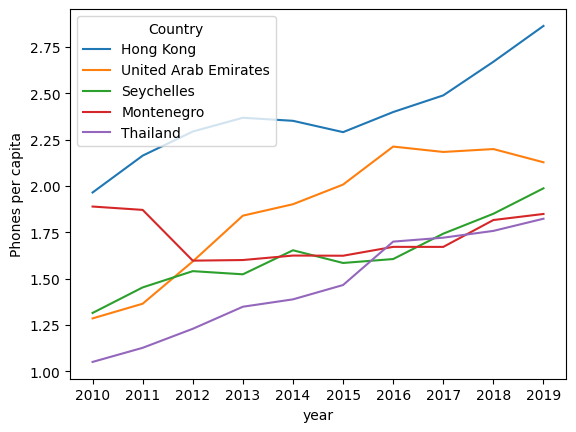

In [53]:
top_10years = percap.sort_values('2019', axis=1, ascending = False).tail(10).iloc[:, :5].reset_index()
top_5_melted = top_5.melt(id_vars=["year"], var_name="Country", value_name="Phones per capita")

sns.lineplot(data=top_5_melted, x="year", y="Phones per capita", hue="Country")

We can observe that Hong Kong has experienced the highest growth over the past 10 years, as it shows the largest increase in phones per capita.

# SQL

In [33]:
import sqlite3 as sql

# Connect to the SQLite database
conn = sql.connect('/Users/siljevik/user_actions.db')  
cursor = conn.cursor()

# Check for tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables found:", tables)

Tables found: [('user_actions',)]


In [34]:
# Define the SQL query to retrieve the 'username' of users who performed a 'signup' action
query1 = """
SELECT username
FROM user_actions
WHERE action = 'signup';
"""

pd.read_sql_query(query1, conn)

,username
0,user34
1,user28
2,user1
3,user24
4,user15
5,user20
6,user18
7,user25
8,user3
9,user9


In [54]:
# Define the SQL query to retrieve user details and the count of their actions
query2 = """
SELECT user_id, username,
    COUNT(action) AS action_count
FROM user_actions
GROUP BY user_id
"""

pd.read_sql_query(query2, conn)

,user_id,username,action_count
0,1,user1,104
1,2,user2,149
2,3,user3,108
3,4,user4,436
4,5,user5,192
5,6,user6,457
6,7,user7,362
7,8,user8,329
8,9,user9,118
9,10,user10,170


In [36]:
query3 = """
SELECT DISTINCT table1.user_id, table1.username
FROM
(SELECT * FROM user_actions WHERE action = 'signup') AS table1
JOIN
(SELECT * FROM user_actions WHERE action = 'login') AS table2
ON DATE(table1.timestamp) = DATE(table2.timestamp) AND table1.user_id = table2.user_id
"""
pd.read_sql(query3, conn)

,user_id,username
0,8,user8
1,12,user12
2,30,user30
3,7,user7
4,22,user22
5,5,user5
6,2,user2
7,32,user32


# Regex

In [39]:
import requests

data = "https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/comments.txt"
response = requests.get(data)
comments_str = response.text

In [38]:
pattern_hashtag = r'#\w+'

hashtag = re.findall(pattern_hashtag,comments_str)
print(hashtag)

['#programming', '#tips', '#coding', '#python', '#tech', '#data', '#programming', '#coding', '#data', '#analysis', '#programming', '#python', '#tips', '#tech', '#innovation', '#coding', '#python', '#data', '#analytics', '#programming', '#tips', '#coding', '#python', '#tech', '#data', '#programming', '#coding', '#data', '#insights', '#programming', '#python', '#tips', '#tech', '#research', '#coding', '#python', '#data', '#analytics', '#programming', '#tips', '#coding', '#innovation', '#programming', '#python', '#tips', '#tech', '#data', '#coding', '#python', '#data', '#analytics', '#programming', '#tips', '#coding', '#python', '#tech', '#innovation', '#programming', '#coding', '#data', '#analytics', '#programming', '#python', '#tips', '#coding', '#innovation', '#tech', '#data', '#programming', '#tips', '#coding', '#python', '#data', '#analysis', '#programming', '#tips', '#coding', '#python', '#tech', '#innovation', '#programming', '#coding', '#data', '#analytics', '#programming', '#tips

In [40]:
pattern2 = r'\d+\.\s".*#programming.*#python.*"'

hashtag2 = re.findall(pattern2,comments_str)
print(hashtag2)

['6. "I learned a lot. #programming #python #tips"', '15. "Well explained. #programming #python #tips"', '21. "Love the content! #programming #python #tips"', '30. "Inspired by the tips. #programming #python #tips"']
